## Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as multi
from scipy.stats import zscore
import scanpy as sc

In [2]:
input_dir <- "../../../../results/method_comparison/compare_algorithms/Similie/community/"

In [3]:
# Read counts data
counts = pd.read_csv(f"{input_dir}counts_corr.csv.gz", compression="gzip")
counts.set_index('gene_symbol', inplace=True)
counts.index.name = None

In [4]:
# Read cell annotations
cells = pd.read_csv(f"{input_dir}anno_cells_corr.txt", sep="\t")
cells.set_index('cell_ID', inplace=True)
cells.index.name = None
cells.rename(columns={'cell_ID.1': 'cell_ID'}, inplace=True)

## Data selection 

In [5]:
gene1 = "OSMR"
gene2 = "IL6ST"
celltype = "Fibroblasts"

In [6]:
threshold_celltype_size = 6
threshold_nr_active_cells = 6
threshold_expr = 0.1

In [7]:
# Subset cells for a specific cell type
sub_cells = cells[cells['cell_type'] == celltype]

In [8]:
# Subset counts based on selected cells and genes
selected_genes = [gene1, gene2]
sub_counts = counts.loc[selected_genes, sub_cells['cell_ID']]

In [9]:
# Transpose the subsetted counts for scatter plot
sub_counts = sub_counts.T

## Preprocessing

In [10]:
length_of_sub_cells = len(sub_cells)
print(f"Length of sub_cells: {length_of_sub_cells}")

Length of sub_cells: 7996


In [11]:
sub_cells_inflamed = sub_cells[sub_cells['region'] == "Inflamed"]
sub_cells_healthy = sub_cells[sub_cells['region'] == "Healthy"]

In [12]:
sub_counts_inflamed = sub_counts.loc[sub_cells_inflamed['cell_ID']]
sub_counts_healthy = sub_counts.loc[sub_cells_healthy['cell_ID']]

In [13]:
unique_sample_ids = sub_cells['sample_ID'].unique()
regions = sub_cells.groupby('sample_ID')['region'].first()

cell_counts = pd.DataFrame(index=unique_sample_ids)
cell_counts['region'] = regions

# Initialize columns with zeros
cell_counts[f'counts_{gene1}'] = 0
cell_counts[f'counts_{gene2}'] = 0
cell_counts['counts_both'] = 0
cell_counts['counts_none'] = 0

In [14]:
for sample_id in unique_sample_ids:
    selected_cells = sub_cells[sub_cells['sample_ID'] == sample_id]
    cell_count = selected_cells.shape[0]  # Count the number of selected cells
    cell_counts.loc[sample_id, 'counts_total'] = cell_count

In [15]:
# Initialize the columns with zeros
cell_counts[f'counts_{gene1}'] = 0
cell_counts[f'counts_{gene2}'] = 0
cell_counts['counts_both'] = 0
cell_counts['counts_none'] = 0
cell_counts['counts_total'] = 0  # Add this line

# Iterate through each sample in cell_counts
for sample_id in cell_counts.index:
    sample_data = sub_cells[sub_cells['sample_ID'] == sample_id]
    sample_cell_ids = sample_data['cell_ID']
    sample_expression = sub_counts.loc[sample_cell_ids]
    
    # Count total cells for the sample
    total_cells = sample_data.shape[0]  # Add this line
    
    # Count cells expressing IL6ST, OSMR, both, and none
    cells_expressing_gene1 = ((sample_expression[gene1] > 0) & (sample_expression[gene2] == 0)).sum()
    cells_expressing_gene2 = ((sample_expression[gene2] > 0) & (sample_expression[gene1] == 0)).sum()
    cells_expressing_both = ((sample_expression[gene1] > 0) & (sample_expression[gene2] > 0)).sum()
    cells_expressing_none = ((sample_expression[gene1] == 0) & (sample_expression[gene2] == 0)).sum()
    
    # Update cell_counts with the calculated values
    cell_counts.loc[sample_id, f'counts_{gene1}'] = cells_expressing_gene1
    cell_counts.loc[sample_id, f'counts_{gene2}'] = cells_expressing_gene2
    cell_counts.loc[sample_id, 'counts_both'] = cells_expressing_both
    cell_counts.loc[sample_id, 'counts_none'] = cells_expressing_none
    cell_counts.loc[sample_id, 'counts_total'] = total_cells  # Add this line

print(cell_counts)


                    region  counts_OSMR  counts_IL6ST  counts_both  \
N10.A_Healthy      Healthy           11            97            6   
N8.A_Healthy       Healthy            6            24            0   
N11.B_Healthy      Healthy            0            14            0   
N15.A_Healthy      Healthy            6            50            4   
N16.A_Healthy      Healthy           11            40            4   
N17.A_Healthy      Healthy            4            28            1   
N18.A_Healthy      Healthy           14            81            6   
N20.A_Healthy      Healthy            3            30            3   
N21.A_Healthy      Healthy           11            25            5   
N51.B_Healthy      Healthy           11           184           34   
N46.A_Healthy      Healthy            8           335           40   
N7.B_Inflamed     Inflamed            6            33            2   
N9.B_Inflamed     Inflamed            4            10            3   
N14.B_Inflamed    In

## Normalization

In [16]:
# Calculate normalization factors
total_celltype_cells = cell_counts['counts_total'].sum()

# Add columns with normalized counts for celltype and sample
cell_counts[f'counts_{gene1}_norm_{celltype}'] = cell_counts[f'counts_{gene1}'] / total_celltype_cells
cell_counts[f'counts_{gene2}_norm_{celltype}'] = cell_counts[f'counts_{gene2}'] / total_celltype_cells
cell_counts[f'counts_both_norm_{celltype}'] = cell_counts['counts_both'] / total_celltype_cells
cell_counts[f'counts_none_norm_{celltype}'] = cell_counts['counts_none'] / total_celltype_cells

# Iterate through each sample in cell_counts
for sample_id in cell_counts.index:
    total_sample_cells = cell_counts.loc[sample_id, 'counts_total']  # Get counts_total for the current sample
    
    # Calculate normalized counts for the current sample
    cell_counts.loc[sample_id, f'counts_{gene1}_norm_{celltype}'] = cell_counts.loc[sample_id, f'counts_{gene1}'] / total_sample_cells
    cell_counts.loc[sample_id, f'counts_{gene2}_norm_{celltype}'] = cell_counts.loc[sample_id, f'counts_{gene2}'] / total_sample_cells
    cell_counts.loc[sample_id, f'counts_both_norm_{celltype}'] = cell_counts.loc[sample_id, 'counts_both'] / total_sample_cells
    cell_counts.loc[sample_id, f'counts_none_norm_{celltype}'] = cell_counts.loc[sample_id, 'counts_none'] / total_sample_cells

    sample_data = cells[cells['sample_ID'] == sample_id]
    sample_cell_ids = sample_data['cell_ID']
    sample_expression = counts[sample_cell_ids]
    length_sample_expression = len(sample_expression)
    
    cell_counts.loc[sample_id, f'counts_{gene1}_norm_sample'] = cell_counts.loc[sample_id, f'counts_{gene1}'] / len(sample_expression)
    cell_counts.loc[sample_id, f'counts_{gene2}_norm_sample'] = cell_counts.loc[sample_id, f'counts_{gene2}'] / len(sample_expression)
    cell_counts.loc[sample_id, 'counts_both_norm_sample'] = cell_counts.loc[sample_id, 'counts_both'] / len(sample_expression)
    cell_counts.loc[sample_id, 'counts_none_norm_sample'] = cell_counts.loc[sample_id, 'counts_none'] / len(sample_expression)
# Print the updated cell_counts DataFrame
print(cell_counts)

                    region  counts_OSMR  counts_IL6ST  counts_both  \
N10.A_Healthy      Healthy           11            97            6   
N8.A_Healthy       Healthy            6            24            0   
N11.B_Healthy      Healthy            0            14            0   
N15.A_Healthy      Healthy            6            50            4   
N16.A_Healthy      Healthy           11            40            4   
N17.A_Healthy      Healthy            4            28            1   
N18.A_Healthy      Healthy           14            81            6   
N20.A_Healthy      Healthy            3            30            3   
N21.A_Healthy      Healthy           11            25            5   
N51.B_Healthy      Healthy           11           184           34   
N46.A_Healthy      Healthy            8           335           40   
N7.B_Inflamed     Inflamed            6            33            2   
N9.B_Inflamed     Inflamed            4            10            3   
N14.B_Inflamed    In

## Application of Tresholds

In [17]:
# Iterate through each sample in cell_counts
for sample_id in cell_counts.index:
    sample_data = cells[(cells['sample_ID'] == sample_id) & (cells['cell_type'] == celltype)]
    sample_cell_ids = sample_data['cell_ID']
    sample_expression = counts[sample_cell_ids]
    
    # Count the total cells for the celltype in the sample
    total_cells = sample_data.shape[0]

    for gene in [gene1, gene2]:
        if gene not in sample_expression.index:
            print(f"Gene {gene} not found in sample expression data.")
            continue

        # Calculate active cells and expressing cells
        active_cells = sample_expression.loc[gene][sample_expression.loc[gene] > threshold_expr]
        expressing_cells = sample_expression.loc[gene][sample_expression.loc[gene] > 0]
        
        # Calculate a_f and e_f
        a_f = len(active_cells) / len(expressing_cells) if len(expressing_cells) > 0 else 0
        e_f = len(expressing_cells) / total_cells if total_cells > 0 else 0

        # Store the calculated values in the cell_counts DataFrame
        cell_counts.loc[sample_id, f'a_f_{gene}'] = a_f
        cell_counts.loc[sample_id, f'e_f_{gene}'] = e_f

# Print updated DataFrame
cell_counts

region  counts_OSMR  counts_IL6ST  counts_both  \
N10.A_Healthy      Healthy           11            97            6   
N8.A_Healthy       Healthy            6            24            0   
N11.B_Healthy      Healthy            0            14            0   
N15.A_Healthy      Healthy            6            50            4   
N16.A_Healthy      Healthy           11            40            4   
N17.A_Healthy      Healthy            4            28            1   
N18.A_Healthy      Healthy           14            81            6   
N20.A_Healthy      Healthy            3            30            3   
N21.A_Healthy      Healthy           11            25            5   
N51.B_Healthy      Healthy           11           184           34   
N46.A_Healthy      Healthy            8           335           40   
N7.B_Inflamed     Inflamed            6            33            2   
N9.B_Inflamed     Inflamed            4            10            3   
N14.B_Inflamed    Inflamed            3            12            1   
N19.B_Inflamed    Inflamed            4            55            5   
N24.B_Inflamed    Inflamed            6            75           11   
N26.B_Inflamed    Inflamed            5            46            8   
N52.B2a_Inflamed  Inflamed            3            80           14   
N58.B1_Inflamed   Inflamed           40           248           24   
N111.B1_Inflamed  Inflamed           38           333           40   
N44.B_Inflamed    Inflamed           17           297           46   
N49.B_Inflamed    Inflamed            7            62           38   
N50.B_Inflamed    Inflamed            7           140           60   
N539.B_Inflamed   Inflamed            9           381           81   
N110.B_Inflamed   Inflamed            8           144           32   
N12.B_Inflamed    Inflamed           29            74           11   
N106.B_Inflamed   Inflamed            5            25           11   

                  counts_none  counts_total  counts_OSMR_norm_Fibroblasts  \
N10.A_Healthy             480           594                      0.018519   
N8.A_Healthy              110           140                      0.042857   
N11.B_Healthy             143           157                      0.000000   
N15.A_Healthy             199           259                      0.023166   
N16.A_Healthy             129           184                      0.059783   
N17.A_Healthy             128           161                      0.024845   
N18.A_Healthy             343           444                      0.031532   
N20.A_Healthy             114           150                      0.020000   
N21.A_Healthy             104           145                      0.075862   
N51.B_Healthy             156           385                      0.028571   
N46.A_Healthy             200           583                      0.013722   
N7.B_Inflamed             137           178                      0.033708   
N9.B_Inflamed              33            50                      0.080000   
N14.B_Inflamed            143           159                      0.018868   
N19.B_Inflamed             72           136                      0.029412   
N24.B_Inflamed             59           151                      0.039735   
N26.B_Inflamed             66           125                      0.040000   
N52.B2a_Inflamed           74           171                      0.017544   
N58.B1_Inflamed           622           934                      0.042827   
N111.B1_Inflamed          324           735                      0.051701   
N44.B_Inflamed            174           534                      0.031835   
N49.B_Inflamed             19           126                      0.055556   
N50.B_Inflamed             66           273                      0.025641   
N539.B_Inflamed            75           546                      0.016484   
N110.B_Inflamed           106           290                      0.027586   
N12.B_Inflamed            209           323              

In [18]:
# Iterate through each sample in cell_counts
for sample_id in cell_counts.index:
    # Subset for cells of the selected celltype
    sample_data = cells[(cells['sample_ID'] == sample_id) & (cells['cell_type'] == celltype)]
    total_cells = sample_data.shape[0]

    # Check celltype size threshold first
    pass_threshold_celltype_size = total_cells > threshold_celltype_size
    
    sample_cell_ids = sample_data['cell_ID']
    sample_expression = counts[sample_cell_ids]  # Assuming 'counts' is your DataFrame with expression data
    
    for gene in [gene1, gene2]:
        if gene not in sample_expression.index:
            print(f"Gene {gene} not found in sample expression data.")
            continue  # Skip this iteration

        # Active cells based on expression level
        active_cells = sample_expression.loc[gene][sample_expression.loc[gene] > threshold_expr]
        
        # Check each threshold
        cell_counts.loc[sample_id, f'pass_threshold_celltype_size_{gene}'] = pass_threshold_celltype_size
        cell_counts.loc[sample_id, f'pass_threshold_nr_active_cells_{gene}'] = len(active_cells) > threshold_nr_active_cells
        #cell_counts.loc[sample_id, f'pass_threshold_expr_{gene}'] = sample_expression.loc[gene].mean() > threshold_expr

# Print the updated cell_counts DataFrame
cell_counts

region  counts_OSMR  counts_IL6ST  counts_both  \
N10.A_Healthy      Healthy           11            97            6   
N8.A_Healthy       Healthy            6            24            0   
N11.B_Healthy      Healthy            0            14            0   
N15.A_Healthy      Healthy            6            50            4   
N16.A_Healthy      Healthy           11            40            4   
N17.A_Healthy      Healthy            4            28            1   
N18.A_Healthy      Healthy           14            81            6   
N20.A_Healthy      Healthy            3            30            3   
N21.A_Healthy      Healthy           11            25            5   
N51.B_Healthy      Healthy           11           184           34   
N46.A_Healthy      Healthy            8           335           40   
N7.B_Inflamed     Inflamed            6            33            2   
N9.B_Inflamed     Inflamed            4            10            3   
N14.B_Inflamed    Inflamed            3            12            1   
N19.B_Inflamed    Inflamed            4            55            5   
N24.B_Inflamed    Inflamed            6            75           11   
N26.B_Inflamed    Inflamed            5            46            8   
N52.B2a_Inflamed  Inflamed            3            80           14   
N58.B1_Inflamed   Inflamed           40           248           24   
N111.B1_Inflamed  Inflamed           38           333           40   
N44.B_Inflamed    Inflamed           17           297           46   
N49.B_Inflamed    Inflamed            7            62           38   
N50.B_Inflamed    Inflamed            7           140           60   
N539.B_Inflamed   Inflamed            9           381           81   
N110.B_Inflamed   Inflamed            8           144           32   
N12.B_Inflamed    Inflamed           29            74           11   
N106.B_Inflamed   Inflamed            5            25           11   

                  counts_none  counts_total  counts_OSMR_norm_Fibroblasts  \
N10.A_Healthy             480           594                      0.018519   
N8.A_Healthy              110           140                      0.042857   
N11.B_Healthy             143           157                      0.000000   
N15.A_Healthy             199           259                      0.023166   
N16.A_Healthy             129           184                      0.059783   
N17.A_Healthy             128           161                      0.024845   
N18.A_Healthy             343           444                      0.031532   
N20.A_Healthy             114           150                      0.020000   
N21.A_Healthy             104           145                      0.075862   
N51.B_Healthy             156           385                      0.028571   
N46.A_Healthy             200           583                      0.013722   
N7.B_Inflamed             137           178                      0.033708   
N9.B_Inflamed              33            50                      0.080000   
N14.B_Inflamed            143           159                      0.018868   
N19.B_Inflamed             72           136                      0.029412   
N24.B_Inflamed             59           151                      0.039735   
N26.B_Inflamed             66           125                      0.040000   
N52.B2a_Inflamed           74           171                      0.017544   
N58.B1_Inflamed           622           934                      0.042827   
N111.B1_Inflamed          324           735                      0.051701   
N44.B_Inflamed            174           534                      0.031835   
N49.B_Inflamed             19           126                      0.055556   
N50.B_Inflamed             66           273                      0.025641   
N539.B_Inflamed            75           546                      0.016484   
N110.B_Inflamed           106           290                      0.027586   
N12.B_Inflamed            209           323              

In [19]:
filtered_df = cell_counts[
    (cell_counts['pass_threshold_celltype_size_OSMR'] == False) |
    (cell_counts['pass_threshold_nr_active_cells_OSMR'] == False) |
    (cell_counts['pass_threshold_celltype_size_IL6ST'] == False) |
    (cell_counts['pass_threshold_nr_active_cells_IL6ST'] == False)
]

filtered_df


region  counts_OSMR  counts_IL6ST  counts_both  counts_none  \
N8.A_Healthy     Healthy            6            24            0          110   
N11.B_Healthy    Healthy            0            14            0          143   
N17.A_Healthy    Healthy            4            28            1          128   
N20.A_Healthy    Healthy            3            30            3          114   
N14.B_Inflamed  Inflamed            3            12            1          143   

                counts_total  counts_OSMR_norm_Fibroblasts  \
N8.A_Healthy             140                      0.042857   
N11.B_Healthy            157                      0.000000   
N17.A_Healthy            161                      0.024845   
N20.A_Healthy            150                      0.020000   
N14.B_Inflamed           159                      0.018868   

                counts_IL6ST_norm_Fibroblasts  counts_both_norm_Fibroblasts  \
N8.A_Healthy                         0.171429                      0.000000   
N11.B_Healthy                        0.089172                      0.000000   
N17.A_Healthy                        0.173913                      0.006211   
N20.A_Healthy                        0.200000                      0.020000   
N14.B_Inflamed                       0.075472                      0.006289   

                counts_none_norm_Fibroblasts  ...  counts_both_norm_sample  \
N8.A_Healthy                        0.785714  ...                 0.000000   
N11.B_Healthy                       0.910828  ...                 0.000000   
N17.A_Healthy                       0.795031  ...                 0.000072   
N20.A_Healthy                       0.760000  ...                 0.000216   
N14.B_Inflamed                      0.899371  ...                 0.000072   

                counts_none_norm_sample  a_f_OSMR  e_f_OSMR  a_f_IL6ST  \
N8.A_Healthy                   0.007936       1.0  0.042857        1.0   
N11.B_Healthy                  0.010317       0.0  0.000000        1.0   
N17.A_Healthy                  0.009235       1.0  0.031056        1.0   
N20.A_Healthy                  0.008225       1.0  0.040000        1.0   
N14.B_Inflamed                 0.010317       1.0  0.025157        1.0   

                e_f_IL6ST  pass_threshold_celltype_size_OSMR  \
N8.A_Healthy     0.171429                               True   
N11.B_Healthy    0.089172                               True   
N17.A_Healthy    0.180124                               True   
N20.A_Healthy    0.220000                               True   
N14.B_Inflamed   0.081761                               True   

                pass_threshold_nr_active_cells_OSMR  \
N8.A_Healthy                                  False   
N11.B_Healthy                                 False   
N17.A_Healthy                                 False   
N20.A_Healthy                                 False   
N14.B_Inflamed                                False   

               pass_threshold_celltype_size_IL6ST  \
N8.A_Healthy                                 True   
N11.B_Healthy                                True   
N17.A_Healthy                                True   
N20.A_Healthy                                True   
N14.B_Inflamed                               True   

               pass_threshold_nr_active_cells_IL6ST  
N8.A_Healthy                                   True  
N11.B_Healthy                                  True  
N17.A_Healthy                                  True  
N20.A_Healthy                                  True  
N14.B_Inflamed                                 True  

[5 rows x 22 columns]

## Plotting

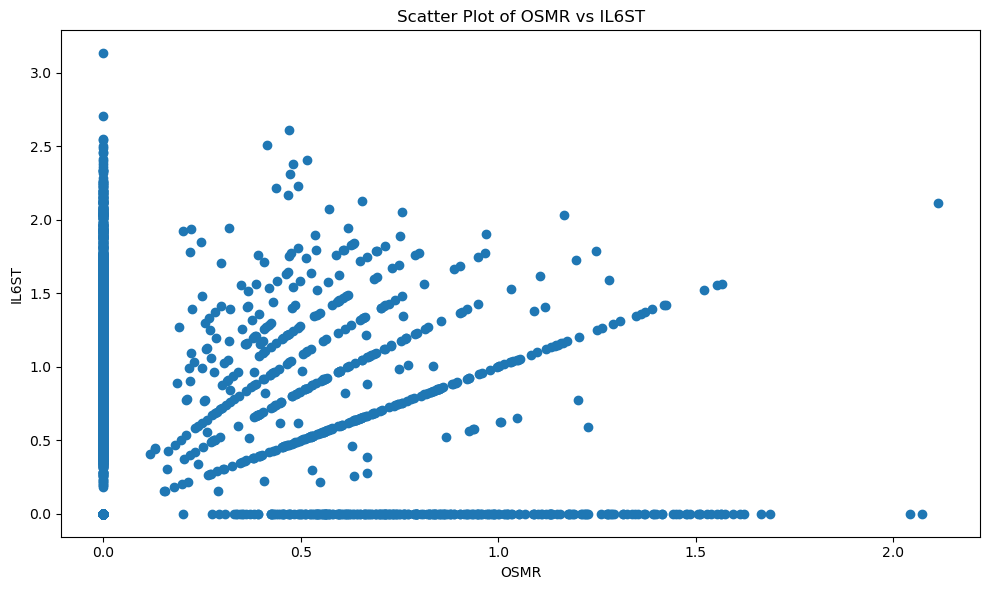

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(sub_counts[gene1], sub_counts[gene2])
plt.xlabel(gene1)
plt.ylabel(gene2)
plt.title(f"Scatter Plot of {gene1} vs {gene2}")
plt.tight_layout()

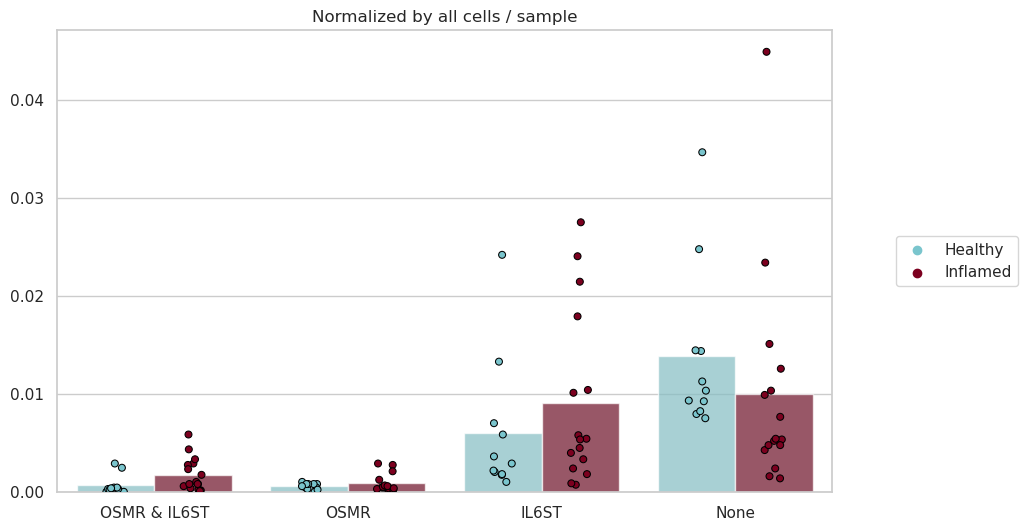

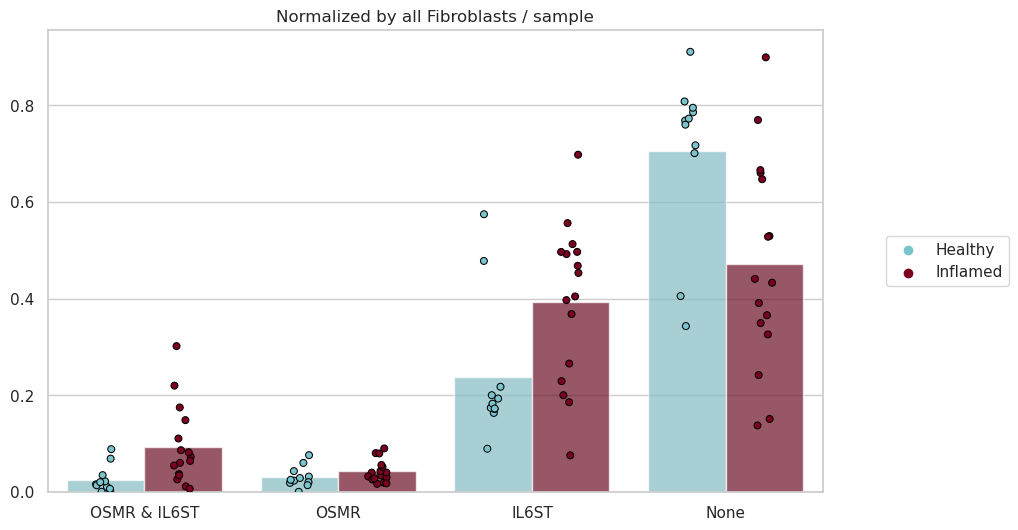

In [21]:
# Prepare the data for plotting
# Convert the wide-form data to long-form suitable for Seaborn plotting
sample_data = pd.melt(cell_counts, id_vars=['region'], value_vars=['counts_both_norm_sample',f'counts_{gene1}_norm_sample', f'counts_{gene2}_norm_sample',  'counts_none_norm_sample'])
celltype_data = pd.melt(cell_counts, id_vars=['region'], value_vars=[f'counts_both_norm_{celltype}',f'counts_{gene1}_norm_{celltype}', f'counts_{gene2}_norm_{celltype}',  f'counts_none_norm_{celltype}'])
palette_custom = {'Healthy': '#7AC5CD', 'Inflamed': '#7C001F'}

# Add the stripplot without its legend
def add_stripplot(ax, data):
    sns.stripplot(x='variable', y='value', hue='region', data=data, dodge=True, 
                  edgecolor="black", linewidth=.75, ax=ax,palette=palette_custom)

# Custom labels for x-axis
custom_labels = [f'{gene1} & {gene2}',f'{gene1}', f'{gene2}',  'None']

# Set Seaborn style
sns.set(style="whitegrid")

# First Bar Chart (Normalized by Sample)
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='variable', y='value', hue='region', data=sample_data, alpha=0.7, errorbar=None,palette=palette_custom)
add_stripplot(ax1, sample_data)
handles1, labels1 = ax1.get_legend_handles_labels()
ax1.legend_.remove()
# Keep only the first two handles to exclude the stripplot legend
ax1.legend(handles1[:2], labels1[:2], loc=7, bbox_to_anchor=(1.25, .5))
plt.title("Normalized by all cells / sample")
ax1.set_xticklabels(custom_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')
plt.show()

# Second Bar Chart (Normalized by Fibroblasts)
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='variable', y='value', hue='region', data=celltype_data, alpha=0.7, errorbar=None,palette=palette_custom)
add_stripplot(ax2, celltype_data)
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend_.remove()
# Keep only the first two handles to exclude the stripplot legend
ax2.legend(handles2[:2], labels2[:2], loc=7, bbox_to_anchor=(1.25, .5))
plt.title(f"Normalized by all {celltype} / sample")
ax2.set_xticklabels(custom_labels)
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.show()

## Statistical tests

In [22]:
# Define the columns to compare
numeric_columns_1 = [f"counts_{gene1}_norm_sample", f"counts_{gene2}_norm_sample", "counts_both_norm_sample", "counts_none_norm_sample"]
numeric_columns_2 = [f"counts_{gene1}", f"counts_{gene2}", "counts_both", "counts_none"]
numeric_columns_3 = [f"counts_{gene1}_norm_{celltype}", f"counts_{gene2}_norm_{celltype}", f"counts_both_norm_{celltype}", f"counts_none_norm_{celltype}"]
# Function to perform t-tests and p-value adjustment
def perform_ttests_and_adjust(cell_counts, numeric_columns):
    p_values = []
    for col_name in numeric_columns:
        group1 = cell_counts[cell_counts['region'] == 'Healthy'][col_name]
        group2 = cell_counts[cell_counts['region'] == 'Inflamed'][col_name]
        t_stat, p_value = ttest_ind(group1, group2, equal_var=False, nan_policy='omit')  # Welch's t-test
        p_values.append(p_value)
    
    # Apply Bonferroni correction
    adjusted_p_values = multi.multipletests(p_values, method='bonferroni')[1]
    
    return pd.DataFrame({
        'Column': numeric_columns,
        'p_value': p_values,
        'adjusted_p_value': adjusted_p_values
    })

# Perform t-tests and p-value adjustment for both sets of columns
results_1 = perform_ttests_and_adjust(cell_counts, numeric_columns_1)
results_2 = perform_ttests_and_adjust(cell_counts, numeric_columns_2)
results_3 = perform_ttests_and_adjust(cell_counts, numeric_columns_3)
combined_results = pd.concat([results_2,results_1, results_3]).reset_index(drop=True)
combined_results

Column   p_value  adjusted_p_value
0                     counts_OSMR  0.224909          0.899635
1                    counts_IL6ST  0.313445          1.000000
2                     counts_both  0.050177          0.200707
3                     counts_none  0.308813          1.000000
4         counts_OSMR_norm_sample  0.224909          0.899635
5        counts_IL6ST_norm_sample  0.313445          1.000000
6         counts_both_norm_sample  0.050177          0.200707
7         counts_none_norm_sample  0.308813          1.000000
8    counts_OSMR_norm_Fibroblasts  0.191114          0.764457
9   counts_IL6ST_norm_Fibroblasts  0.016767          0.067069
10   counts_both_norm_Fibroblasts  0.006061          0.024243
11   counts_none_norm_Fibroblasts  0.004577          0.018309

## Saving cell_counts

In [25]:
cell_counts.to_csv(f"{input_dir}cell_counts_{gene1}_{gene2}_{celltype}.tsv", sep='\t')